In [2]:
# add necessary imports
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 1000)

In [3]:
#Read the data
df_analyse=pd.read_csv('../data/processed/small_table_updated.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).tail()

,date,US,India,Germany,Italy,Australia,SIR_Italy,SIR_Germany,SIR_Aus,SIR_US
875,2022-06-15,85941290,43257730,27096571,17736696,7724035,1.817410e+07,2.955172e+07,8.208324e+06,1.196622e+08
876,2022-06-16,86057735,43270577,27124689,17773764,7753800,1.822659e+07,2.971245e+07,8.282708e+06,1.203707e+08
877,2022-06-17,86216418,43283793,27204953,17809934,7778643,1.827915e+07,2.987398e+07,8.357766e+06,1.210835e+08
878,2022-06-18,86230982,43296692,27204955,17844905,7801241,1.833177e+07,3.003630e+07,8.433504e+06,1.218005e+08
879,2022-06-19,86246101,43309473,27211896,17879160,7825659,1.838445e+07,3.019943e+07,8.509929e+06,1.225217e+08


In [4]:
#df_analyse['India']

In [5]:
# reference: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
# beta/gamma is denoted as basic reproduction number.

N= 10000000 #10000000 # max susceptible population = It is also the country's entire population
I0=df_analyse.India[110] # No. of days required to get a total infections of around 100.
R0=0
S0=N-(I0+R0)
# condition I0+S0+R0=N0


beta=0.4   # infection spread dynamics = It represents how many people can be infected from a single person. (here 0.4 means 4 people can get infected from 1 person)
gamma=0.1  # recovery rate

ydata = np.array(df_analyse.India[110:])
t=np.arange(len(ydata)) #time period


In [6]:
# SIR stands for S- susceptible, I - infected, R- recovered. The model suits perfectly for COVID scenario.
# NOTE: SIR model works on the assumption that recovered people will not get the infection again.
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: infected rate
        gamma: recovery rate
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N    
    dI_dt=beta*S*I/N-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

#Integrate the SIR equations over the time grid, t.
def fit_odeint(x, beta, gamma):
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [7]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([ 7.07680000e+04,  9.51975988e+04,  1.27866238e+05,  1.71397510e+05,
        2.29128533e+05,  3.05209118e+05,  4.04637042e+05,  5.33157406e+05,
        6.96921957e+05,  9.01783225e+05,  1.15212014e+06,  1.44920241e+06,
        1.78933640e+06,  2.16235785e+06,  2.55127428e+06,  2.93373338e+06,
        3.28534738e+06,  3.58398305e+06,  3.81354653e+06,  3.96601816e+06,
        4.04136585e+06,  4.04585627e+06,  3.98968460e+06,  3.88472312e+06,
        3.74282268e+06,  3.57476162e+06,  3.38973923e+06,  3.19524622e+06,
        2.99715713e+06,  2.79992998e+06,  2.60684069e+06,  2.42021130e+06,
        2.24161340e+06,  2.07203945e+06,  1.91204271e+06,  1.76184864e+06,
        1.62144229e+06,  1.49063607e+06,  1.36912161e+06,  1.25650933e+06,
        1.15235827e+06,  1.05619841e+06,  9.67547168e+05,  8.85921572e+05,
        8.10846899e+05,  7.41862812e+05,  6.78527515e+05,  6.20420427e+05,
        5.67143738e+05,  5.18323144e+05,  4.73607965e+05,  4.32670829e+05,
        3.95207031e+05,  

In [8]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

standard deviation errors :  [1.09884809e-03 1.02553742e-05]  start infect: 70768
Optimal parameters: beta = 0.03883003809358477  and gamma =  -0.0025853646745687036


In [9]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

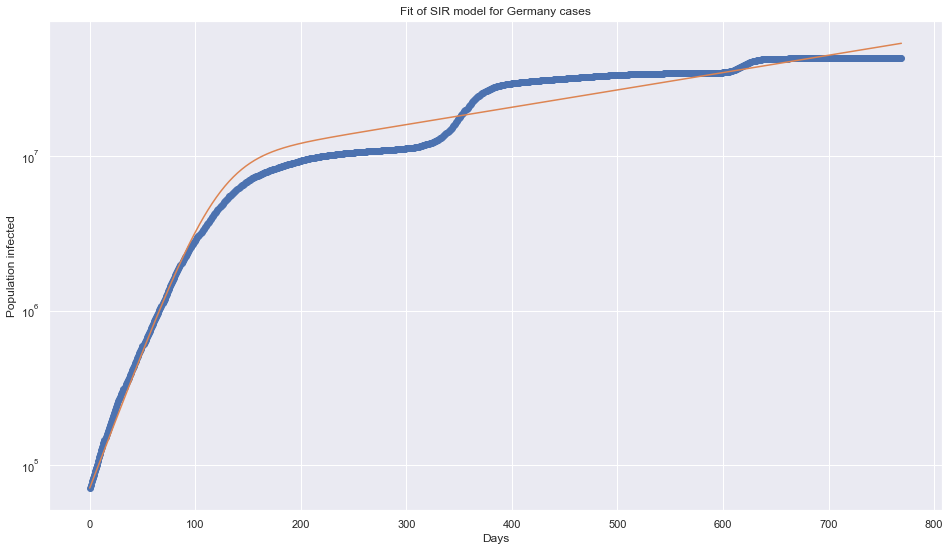

Optimal parameters: beta = 0.03883003809358477  and gamma =  -0.0025853646745687036
Basic Reproduction Number R0  -15.019172527396927
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [10]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

SyntaxError: EOF while scanning triple-quoted string literal (Temp/ipykernel_5936/3857640367.py, line 1)

In [11]:
SIR_India = np.concatenate([np.zeros(110,dtype=float), fitted])
df_analyse['SIR_India'] = SIR_India

In [12]:
data_path='../data/processed/small_table_updated.csv'
df_analyse.to_csv(data_path, sep=';', index=False)

In [13]:
df_analyse=pd.read_csv('../data/processed/small_table_updated.csv',sep=';', index_col=False)  
df_analyse.sort_values('date',ascending=True).tail()

,date,US,India,Germany,Italy,Australia,SIR_Italy,SIR_Germany,SIR_Aus,SIR_US,SIR_India
875,2022-06-15,85941290,43257730,27096571,17736696,7724035,1.817410e+07,2.955172e+07,8.208324e+06,1.196622e+08,5.334343e+07
876,2022-06-16,86057735,43270577,27124689,17773764,7753800,1.822659e+07,2.971245e+07,8.282708e+06,1.203707e+08,5.348152e+07
877,2022-06-17,86216418,43283793,27204953,17809934,7778643,1.827915e+07,2.987398e+07,8.357766e+06,1.210835e+08,5.361997e+07
878,2022-06-18,86230982,43296692,27204955,17844905,7801241,1.833177e+07,3.003630e+07,8.433504e+06,1.218005e+08,5.375878e+07
879,2022-06-19,86246101,43309473,27211896,17879160,7825659,1.838445e+07,3.019943e+07,8.509929e+06,1.225217e+08,5.389794e+07
